# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.Также выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

HR-агентство хочет ответить на следующие вопросы:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Уровень значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о зарплатах в сфере Data Science за 2020–2022 годы.

Данные содержат следующие столбцы:
*   *work_year* — год, в котором была выплачена зарплата.;
*   *experience_level* — опыт работы на этой должности в течение года со следующими возможными значениями: EN — Entry-level/Junior, MI — Mid-level/Intermediate, SE — Senior-level/Expert, EX — Executive-level/Director;
*   *employment_type* — тип трудоустройства для этой роли: PT — неполный рабочий день, FT — полный рабочий день, CT — контракт, FL — фриланс;
*   *job_title* — роль, в которой соискатель работал в течение года;
*   *salary* — общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
*   *employee_residence	* — основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — общий объём работы, выполняемой удалённо. Возможные значения: 0 — удалённой работы нет (менее 20 %), 50 — частично удалённая работа, 100 — полностью удалённая работа (более 80 %);
*   *company_location* — страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* — среднее количество людей, работавших в компании в течение года: S — менее 50 сотрудников (небольшая компания), M — от 50 до 250 сотрудников (средняя компания), L — более 250 сотрудников (крупная компания).

Источник датасета: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [701]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px

In [3]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col=0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [341]:
df = data.copy()

In [5]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [342]:
print('Количество дубликатов: {}'.format(df[df.duplicated()].shape[0]))

# Удаляем дубликаты:
df = df.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(df.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


In [343]:
# тип данных с столбце 'remote_ratio' не соответсвует категориальному признаку,
# изменим его на строчный и заменим названия категорий.
df['remote_ratio'] = df['remote_ratio'].apply(lambda x: 'удалённой работы нет' if x==0 
                                               else ('частично удалённая работа' if x==50
                                                     else 'полностью удалённая работа'))

Неинформативными признаками являются 'salary' и 'salary_currency', потому что уже есть столбец с заработной платой в одинаковых денежных единицах. В исследовании эти признаки участвовать не будут.

К числовым признакам относятся: 'salary_in_usd', 'salary'. Считаю что признак 'work_year' в данном случае является скорее категориальным, потому что значений всего три, по тому же условию 'remote_ratio' также отношу к категориальным. Все остальные признаки также являются категориальными.

In [344]:
# удаляем столбцы "salary" и "salary_currency"
df = df.drop(columns=['salary', 'salary_currency'])

In [345]:
df_agg = df.describe().round(2)
df_agg

,work_year,salary_in_usd
count,565.00,565.00
mean,2021.36,110610.34
std,0.70,72280.70
min,2020.00,2859.00
25%,2021.00,60757.00
50%,2021.00,100000.00
75%,2022.00,150000.00
max,2022.00,600000.00


In [346]:
# создаем столбец для фильтрации профессий по принадлежности к 'Data Scientist' или 'Data Engineer'
df['DS_or_DE'] = df['job_title']. apply(lambda x: 'DS' if x=='Data Scientist' else ('DE' if x=='Data Engineer' else 'Other'))
df

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,DS_or_DE
0,2020,MI,FT,Data Scientist,79833,DE,удалённой работы нет,DE,L,DS
1,2020,SE,FT,Machine Learning Scientist,260000,JP,удалённой работы нет,JP,S,Other
2,2020,SE,FT,Big Data Engineer,109024,GB,частично удалённая работа,GB,M,Other
3,2020,MI,FT,Product Data Analyst,20000,HN,удалённой работы нет,HN,S,Other
4,2020,SE,FT,Machine Learning Engineer,150000,US,частично удалённая работа,US,L,Other
...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,полностью удалённая работа,US,M,DE
603,2022,SE,FT,Data Engineer,126000,US,полностью удалённая работа,US,M,DE
604,2022,SE,FT,Data Analyst,129000,US,удалённой работы нет,US,M,Other
605,2022,SE,FT,Data Analyst,150000,US,полностью удалённая работа,US,M,Other


***

## Визуальный анализ данных

#### Распределение страховых выплат по всем клиентам

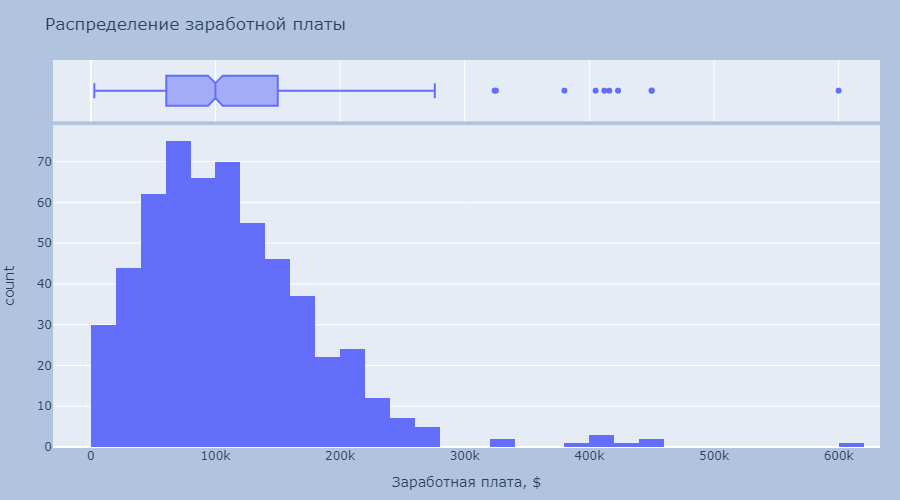

In [349]:
#строим график
fig = px.histogram(
    df, #табличные данные
    x='salary_in_usd', #ось абсцисс
    title='Распределение заработной платы', #заголовок
    labels={'salary_in_usd':'Заработная плата, $'}, #название оси x
    marginal='box', #дополнительный график
    nbins=30, #количество интервалов
    height=500, #высота
    width=900 #ширина
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show("png")

Распределение заработной платы отличается от нормального хотя и близко к нему, к тому же имеются выбросы. Медианная заработная плата составляет 100 тысяч долларов, большинство получает от 60 тысяч до 150 тысяч долларов.

***

#### 1. Год, в котором была выплачена зарплата

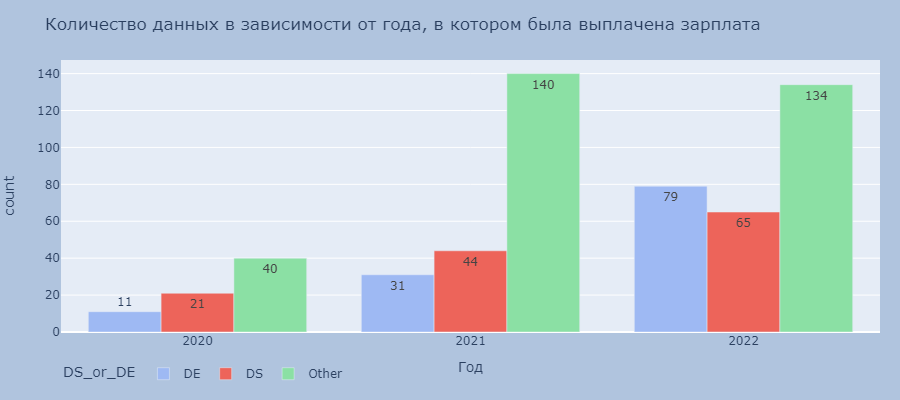

In [299]:
#группируем данные
bar_year_cnt = df.groupby(['work_year', 'DS_or_DE'], as_index=False)['salary_in_usd'].count()


#строим график
fig = px.bar(
    bar_year_cnt, #табличные данные
    x='work_year', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Количество данных в зависимости от года, в котором была выплачена зарплата', #заголовок
    labels={'work_year':'Год',
            'salary_in_usd':'count'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    legend = dict(orientation='h')
)

#отображаем график
fig.show('png')

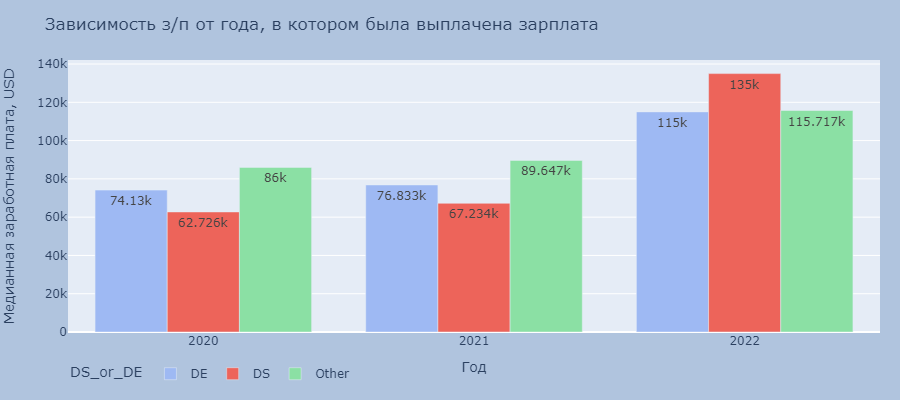

In [298]:
#группируем данные
bar_year_dep = df.groupby(['work_year', 'DS_or_DE'], as_index=False)['salary_in_usd'].median().round()


#строим график
fig = px.bar(
    bar_year_dep, #табличные данные
    x='work_year', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Зависимость з/п от года, в котором была выплачена зарплата', #заголовок
    labels={'work_year':'Год',
            'salary_in_usd':'Медианная заработная плата, USD'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    legend = dict(orientation='h')
)

#отображаем график
fig.show('png')

In [350]:
#группируем данные
fig = px.box(
    df, #табличные данные
    x='work_year', #ось абсцисс
    y='salary_in_usd', #ось ординат
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.D3[3], px.colors.qualitative.Safe[3],
                             px.colors.qualitative.D3[0]], #настройка цвета
    title='Распределение з/п в зависимости от года, в котором была выплачена зарплата', #заголовок
    labels={'work_year':'Год',
            'salary_in_usd':'Заработная плата, USD'}, #названия осей абсцисс и ординат
    height=600, #высота
    width=900 #ширина
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    legend = dict(orientation='h')
)

#отображаем график
fig.show()

Наибольший рост заработных плат у всех наблюдается в 2022 году. Взрывной рост наблюдаем у DS - если в 2021 з/п DS выросла совсем немного, то в 2022 в два раза. У всех остальных также наблюдается ежегодный стабильный рост. Также присуствуют выбросы.

#### 2. Опыт работы на этой должности в течение года

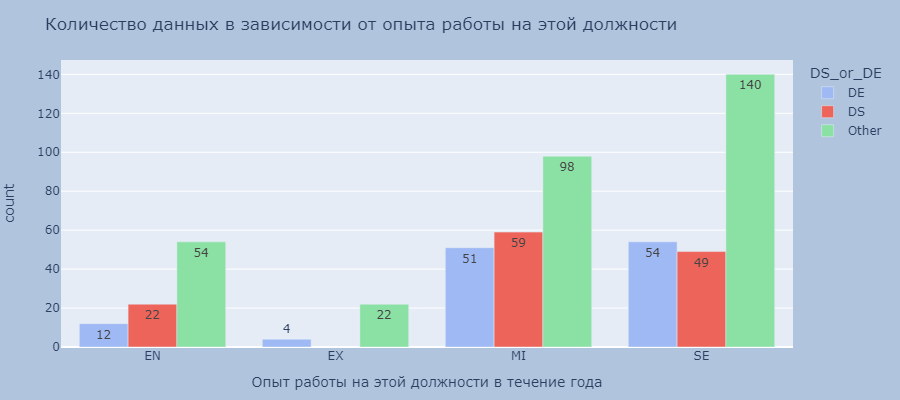

In [302]:
#группируем данные
bar_exp_cnt = df.groupby(['experience_level', 'DS_or_DE'], as_index=False)['salary_in_usd'].count()


#строим график
fig = px.bar(
    bar_exp_cnt, #табличные данные
    x='experience_level', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Количество данных в зависимости от опыта работы на этой должности', #заголовок
    labels={'experience_level':'Опыт работы на этой должности в течение года',
            'salary_in_usd':'count'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

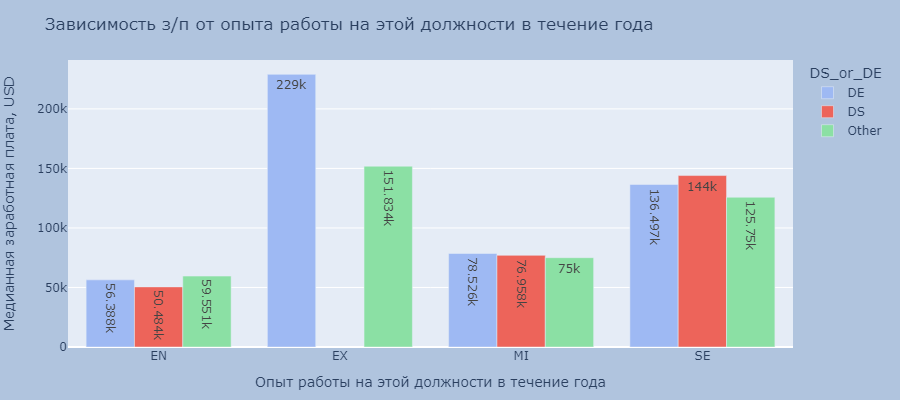

In [303]:
#группируем данные
bar_data = df.groupby(['experience_level', 'DS_or_DE'], as_index=False)['salary_in_usd'].median().round()

#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='experience_level', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Зависимость з/п от опыта работы на этой должности в течение года', #заголовок
    labels={'experience_level':'Опыт работы на этой должности в течение года',
            'salary_in_usd':'Медианная заработная плата, USD'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

In [351]:
#строим график
fig = px.box(
    df, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y='experience_level', #ось ординат
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.D3[3], px.colors.qualitative.Safe[3],
                             px.colors.qualitative.D3[0]], #настройка цвета
    title='Распределение з/п в зависимости от опыта работы на этой должности в течение года', #заголовок
    labels={'experience_level':'Опыт работы на этой должности в течение года',
            'salary_in_usd':'Заработная плата, USD'}, #названия осей абсцисс и ординат
    height=600, #высота
    width=900 #ширина
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show()

Как и ожидалось - чем больше опыта у работника, тем выше его заработная плата. Наибольший рост наблюдаем начиная с категории "SE". Рост заработных плат в разрезе опыта не зависит от профессии, но зависит от того насколько сотрудник опытен. Почти везде выбросы.

#### 3. Тип трудоустройства для этой роли

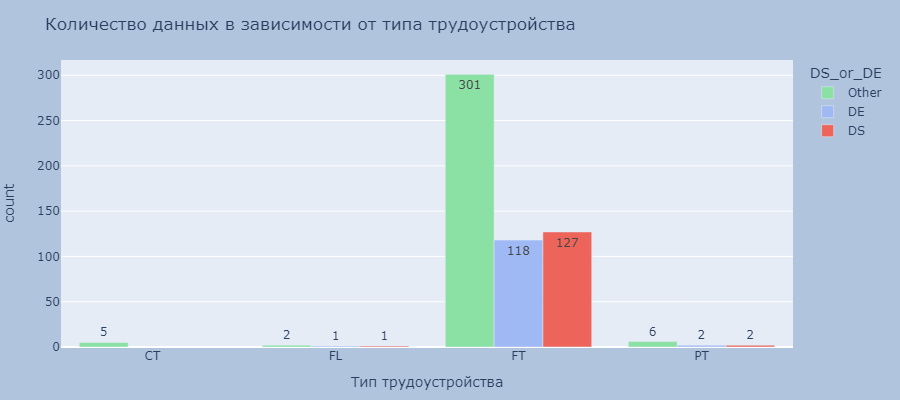

In [308]:
#группируем данные
bar_data = df.groupby(['employment_type', 'DS_or_DE'], as_index=False)['salary_in_usd'].count()


#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='employment_type', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[8], px.colors.qualitative.Pastel[5],
                             px.colors.qualitative.Vivid[9]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Количество данных в зависимости от типа трудоустройства', #заголовок
    labels={'employment_type':'Тип трудоустройства',
            'salary_in_usd':'count'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

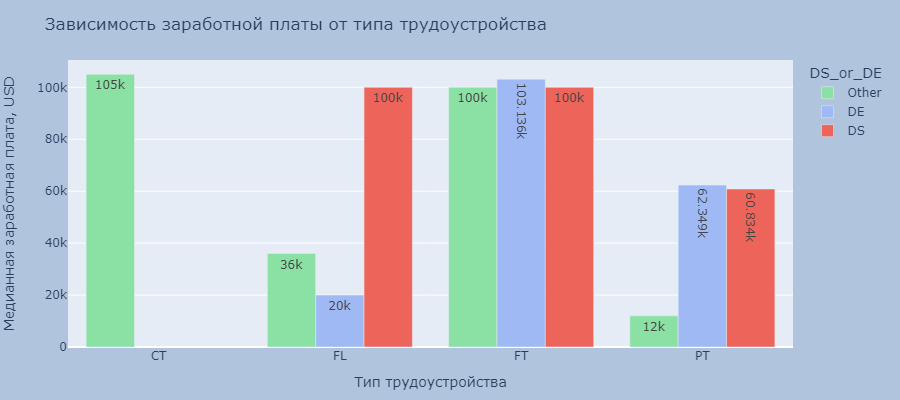

In [309]:
#группируем данные
bar_data = df.groupby(['employment_type', 'DS_or_DE'], as_index=False)['salary_in_usd'].median().round()

#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='employment_type', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[8], px.colors.qualitative.Pastel[5],
                             px.colors.qualitative.Vivid[9]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Зависимость заработной платы от типа трудоустройства', #заголовок
    labels={'employment_type':'Тип трудоустройства',
            'salary_in_usd':'Медианная заработная плата, USD'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

In [310]:
#строим график
fig = px.box(
    df, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y='employment_type', #ось ординат
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.D3[3], px.colors.qualitative.Safe[3],
                             px.colors.qualitative.D3[0]], #настройка цвета
    title='Распределение з/п в зависимости от типа трудоустройства', #заголовок
    labels={'employment_type':'Тип трудоустройства',
            'salary_in_usd':'Заработная плата, USD'}, #названия осей абсцисс и ординат
    height=600, #высота
    width=900 #ширина
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show()

Очень мало данных по всем категориям кроме 'FT'(полный рабочий день), в этой категории медианные зарплаты почти равны. При частичной занятости з/п DS и DE примерно равны, а вот у остальных значительно ниже. По сути достаточное количество данных, чтобы сделать какие-либо выводы, достаточно только у категории фулл тайм. При частичной занятости есть 6 сотрудников у "остальных" профессий и все их зарплаты очень низкие - медианная 12 тысяч долларов. Присутствуют выбросы.

#### 4. Роль, в которой соискатель работал в течение года.

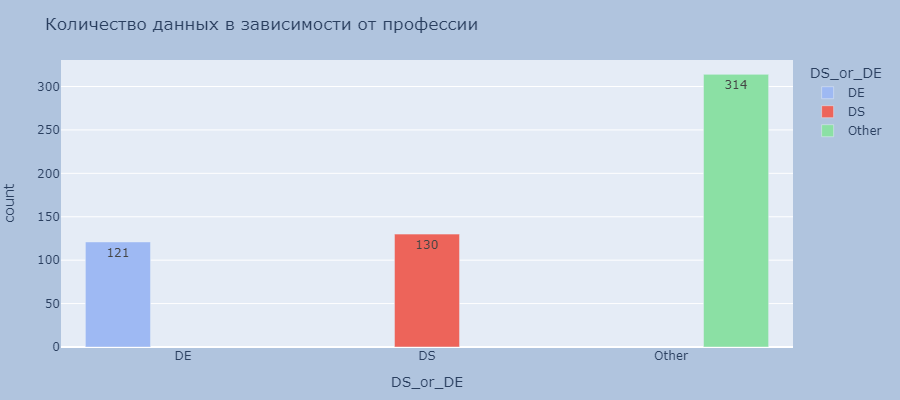

In [318]:
#группируем данные
bar_data = df.groupby('DS_or_DE', as_index=False)['salary_in_usd'].count()

#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='DS_or_DE', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color= 'DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Количество данных в зависимости от профессии', #заголовок
    labels={'job_title':'Название профессии',
            'salary_in_usd':'count'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

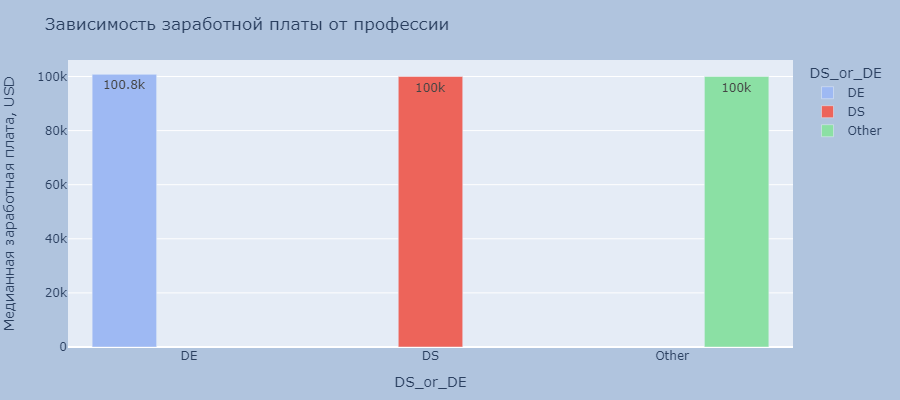

In [319]:
#группируем данные
bar_data = df.groupby('DS_or_DE', as_index=False)['salary_in_usd'].median().round(0)


#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='DS_or_DE', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color= 'DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Зависимость заработной платы от профессии', #заголовок
    labels={'job_title':'Название профессии',
            'salary_in_usd':'Медианная заработная плата, USD'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

In [322]:
#группируем данные
box_data = df[['salary_in_usd', 'DS_or_DE']]

#строим график
fig = px.box(
    box_data, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y='DS_or_DE', #ось ординат
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.D3[3], px.colors.qualitative.Safe[3],
                             px.colors.qualitative.D3[0]], #настройка цвета
    title='Распределение з/п в зависимости от профессии', #заголовок
    labels={'job_title':'Название профессии',
            'salary_in_usd':'Распределение заработной платы, USD'}, #названия осей абсцисс и ординат
    height=600, #высота
    width=900 #ширина
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show()

У DS, DE(без добавлений) и 'Other' медианные заработные платы примерно равны. Выбросов немного, но они есть у всех категорий. Большинство DS получают заработную плату от 50 тысяч до 140 тысяч долларов.

#### 5. Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.

In [316]:
#создаем список индексов для фильтрации
list_hist = df['employee_residence'].value_counts().head(7).index
list_hist

Index(['US', 'GB', 'IN', 'CA', 'DE', 'FR', 'ES'], dtype='object', name='employee_residence')

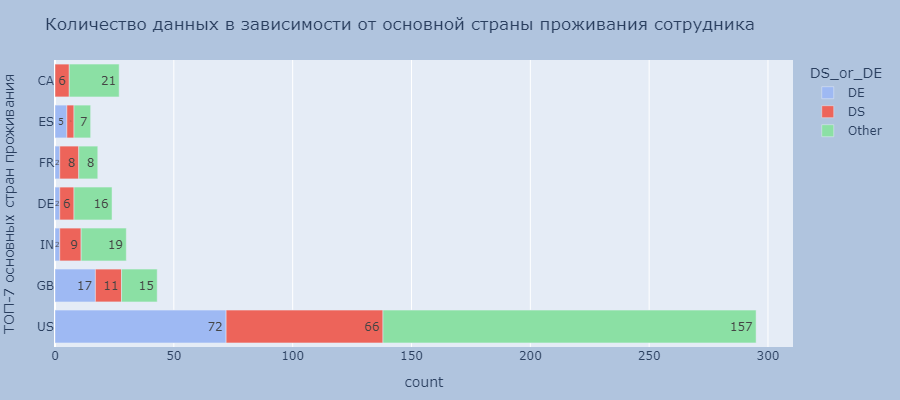

In [323]:
#группируем данные
hist_data = df.groupby(['employee_residence', 'DS_or_DE'])[['salary_in_usd']].count().loc[list_hist]


#строим график
fig = px.bar(
    hist_data, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y=hist_data.index.get_level_values(0), #ось ординат
    color=hist_data.index.get_level_values(1),
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Количество данных в зависимости от основной страны проживания сотрудника', #заголовок
    labels={'y':'ТОП-7 основных стран проживания',
            'salary_in_usd':'count',
            'color':'DS_or_DE'
    } #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

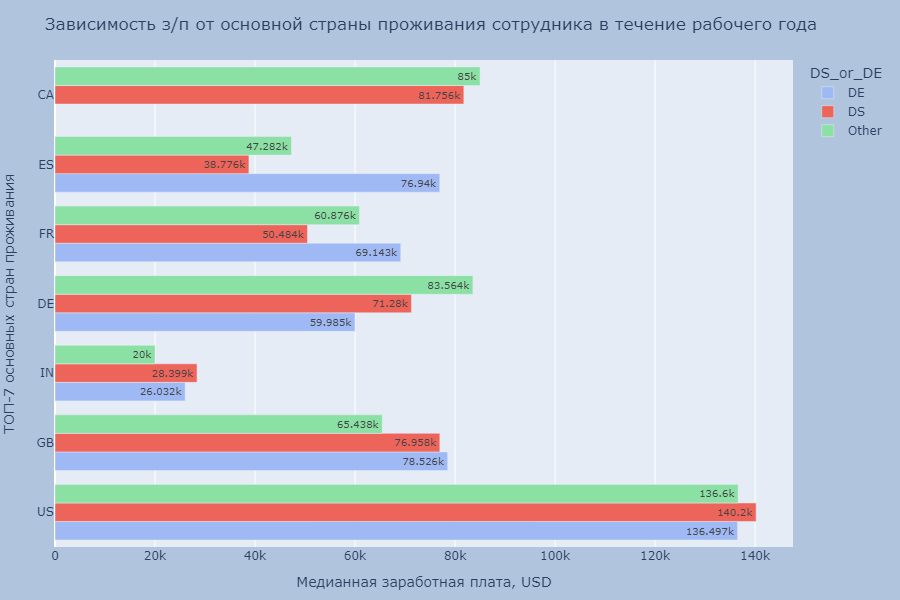

In [324]:
#группируем данные
bar_data = df.groupby(['employee_residence', 'DS_or_DE'])[['salary_in_usd']].median().loc[list_hist].round()


#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y=bar_data.index.get_level_values(0), #ось ординат
    barmode='group', #режим диаграммы
    color=bar_data.index.get_level_values(1),
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=600, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Зависимость з/п от основной страны проживания сотрудника в течение рабочего года', #заголовок
    labels={'y':'ТОП-7 основных стран проживания',
            'salary_in_usd':'Медианная заработная плата, USD',
            'color':'DS_or_DE'
    } #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

ТОП-7 сгруппирован по количеству данных. Наибольший уровень з/п во всех категориях в США(US). Очень выделяется Индия, из представленных в ТОП-7 стран в здесь самые маленькие з/п во всех категориях. В Англии, Канаде, Франции и Испании DE зарабатывают больше всех остальных категорий. В Индии и США медианные з/п выше всех у DS.

#### 6. Общий объём работы, выполняемой удалённо.

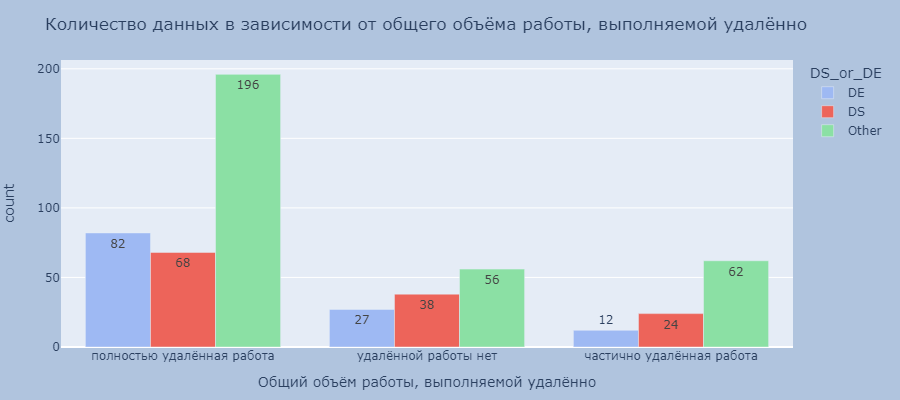

In [325]:
#группируем данные
bar_exp_cnt = df.groupby(['remote_ratio', 'DS_or_DE'], as_index=False)['salary_in_usd'].count()


#строим график
fig = px.bar(
    bar_exp_cnt, #табличные данные
    x='remote_ratio', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Количество данных в зависимости от общего объёма работы, выполняемой удалённо', #заголовок
    labels={'remote_ratio':'Общий объём работы, выполняемой удалённо',
            'salary_in_usd':'count'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

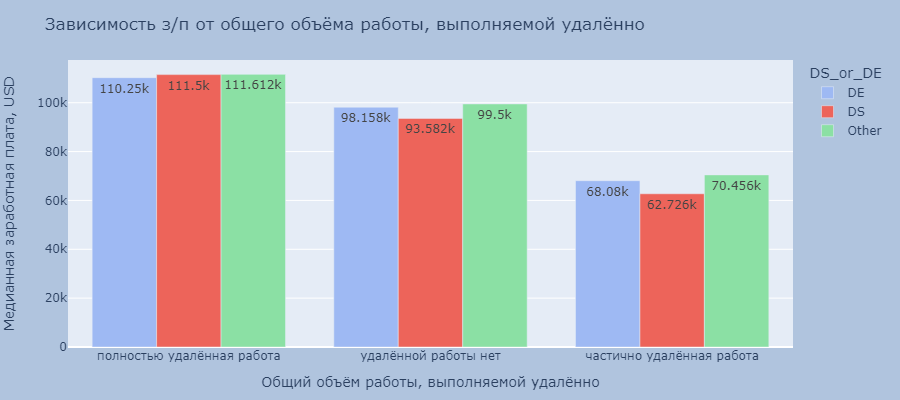

In [327]:
#группируем данные
bar_data = df.groupby(['remote_ratio', 'DS_or_DE'], as_index=False)['salary_in_usd'].median().round()

#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='remote_ratio', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Зависимость з/п от общего объёма работы, выполняемой удалённо', #заголовок
    labels={'remote_ratio':'Общий объём работы, выполняемой удалённо',
            'salary_in_usd':'Медианная заработная плата, USD'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

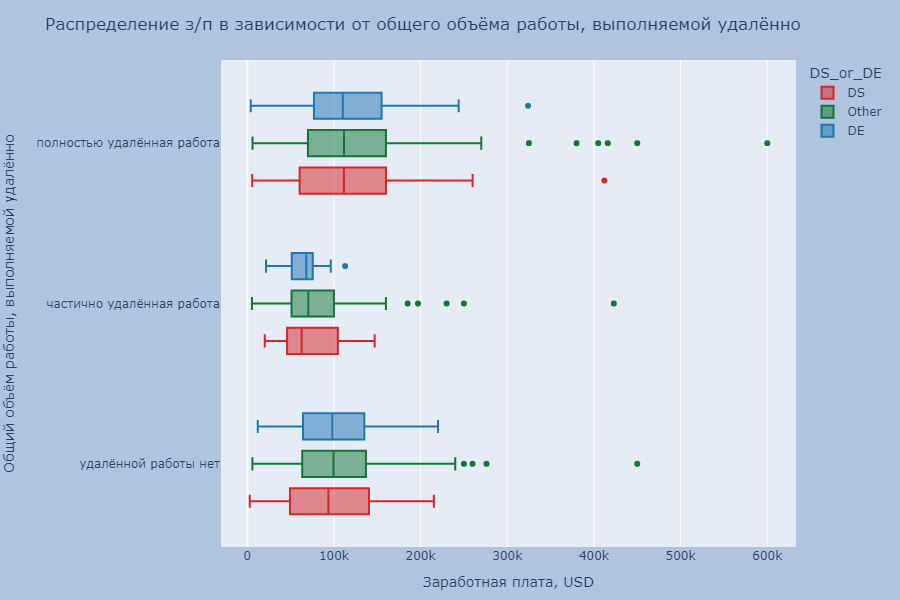

In [328]:
#строим график
fig = px.box(
    df, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y='remote_ratio', #ось ординат
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.D3[3], px.colors.qualitative.Safe[3],
                             px.colors.qualitative.D3[0]], #настройка цвета
    title='Распределение з/п в зависимости от общего объёма работы, выполняемой удалённо', #заголовок
    labels={'remote_ratio':'Общий объём работы, выполняемой удалённо',
            'salary_in_usd':'Заработная плата, USD'}, #названия осей абсцисс и ординат
    height=600, #высота
    width=900 #ширина
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

Больше остальных зарабатывают люди, работающие удаленно, немного меньше работающие полностью в офисе, и меньше остальных зарабатывают люди, работаюшие по комбинированному графику(частично удаленно). Везде есть выбросы. От профессии медианные зарплаты сильно не изменяются.

#### 7. Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.

In [329]:
#создаем список индексов для фильтрации
list_hist = df['company_location'].value_counts().head(7).index
list_hist

Index(['US', 'GB', 'CA', 'DE', 'IN', 'FR', 'ES'], dtype='object', name='company_location')

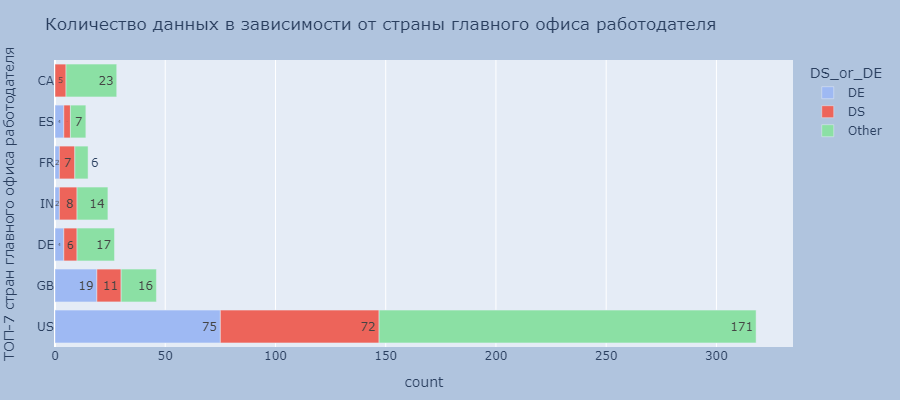

In [330]:
#группируем данные
hist_data = df.groupby(['company_location', 'DS_or_DE'])[['salary_in_usd']].count().loc[list_hist]


#строим график
fig = px.bar(
    hist_data, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y=hist_data.index.get_level_values(0), #ось ординат
    color=hist_data.index.get_level_values(1),
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Количество данных в зависимости от страны главного офиса работодателя', #заголовок
    labels={'y':'ТОП-7 стран главного офиса работодателя',
            'salary_in_usd':'count',
            'color':'DS_or_DE'
    } #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

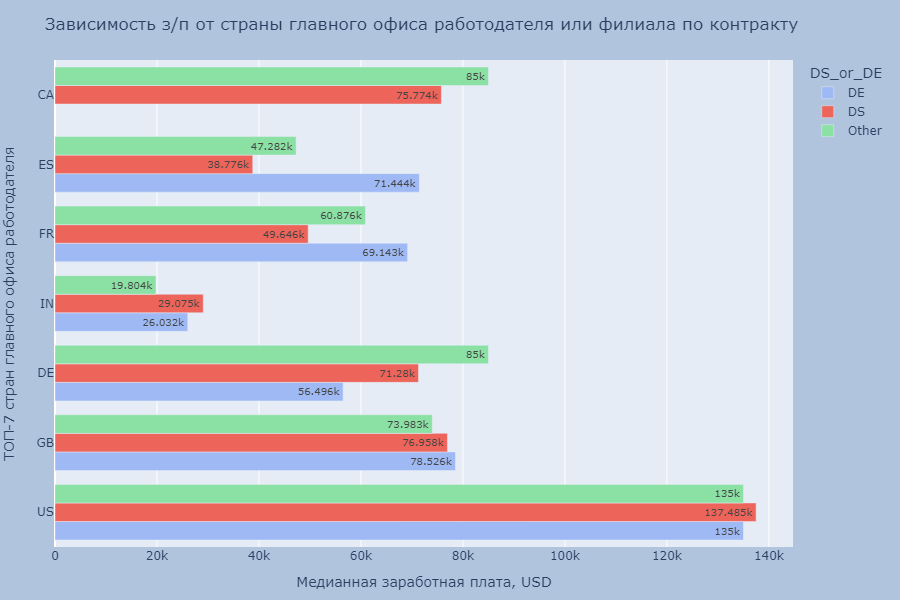

In [331]:
#группируем данные
bar_data = df.groupby(['company_location', 'DS_or_DE'])[['salary_in_usd']].median().loc[list_hist].round()


#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y=bar_data.index.get_level_values(0), #ось ординат
    barmode='group', #режим диаграммы
    color=bar_data.index.get_level_values(1),
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=600, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Зависимость з/п от страны главного офиса работодателя или филиала по контракту', #заголовок
    labels={'y':'ТОП-7 стран главного офиса работодателя',
            'salary_in_usd':'Медианная заработная плата, USD',
            'color':'DS_or_DE'
    } #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

ТОП-7 также отобран по количеству данных в целевом столбце. Большинство офисов расположены в США. Наиболее высокие з/п также в компаниях, расположенных в США. Самые маленькие з/п в Индии. В целом картина похожа на графики в пункте 5 - "основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166". И заработные платы не имеют существенных различий(между графиками), несмотря на то что в нашем датасете много сотрудников работающих удаленно, из чего можно сделать вывод о том что большинство сотрудников даже работая удаленно в основном работают в компаниях, имеющих офис в стране проживания сотрудника.

#### 8. Среднее количество людей, работавших в компании в течение года

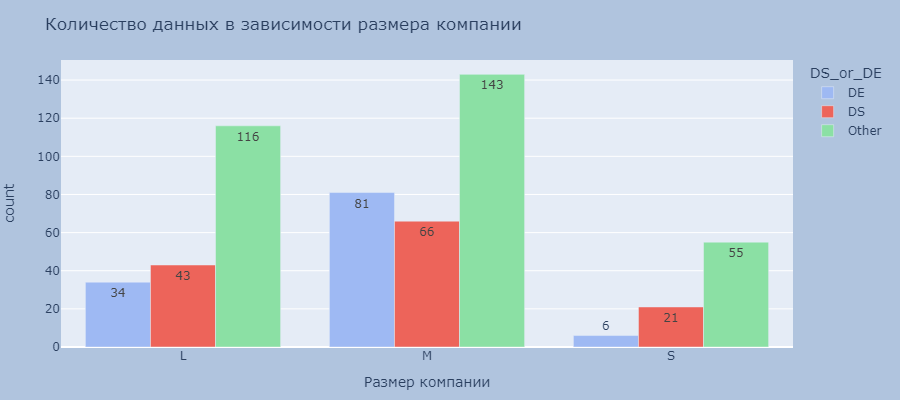

In [352]:
#группируем данные
bar_exp_cnt = df.groupby(['company_size', 'DS_or_DE'], as_index=False)['salary_in_usd'].count()


#строим график
fig = px.bar(
    bar_exp_cnt, #табличные данные
    x='company_size', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Количество данных в зависимости размера компании', #заголовок
    labels={'company_size':'Размер компании',
            'salary_in_usd':'count'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

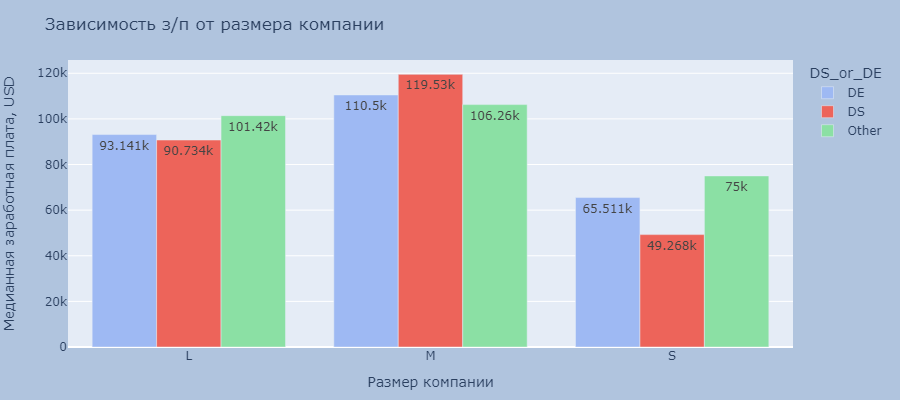

In [353]:
#группируем данные
bar_data = df.groupby(['company_size', 'DS_or_DE'], as_index=False)['salary_in_usd'].median().round()

#строим график
fig = px.bar(
    bar_data, #табличные данные
    x='company_size', #ось абсцисс
    y='salary_in_usd', #ось ординат
    barmode='group', #режим диаграммы
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.Pastel[5], px.colors.qualitative.Vivid[9],
                             px.colors.qualitative.Pastel[8]], #настройка цвета
    height=400, #высота
    width=900, #ширина
    text_auto=True, #выводим надписи
    title='Зависимость з/п от размера компании', #заголовок
    labels={'company_size':'Размер компании',
            'salary_in_usd':'Медианная заработная плата, USD'} #название осей абсцисс и ординат
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

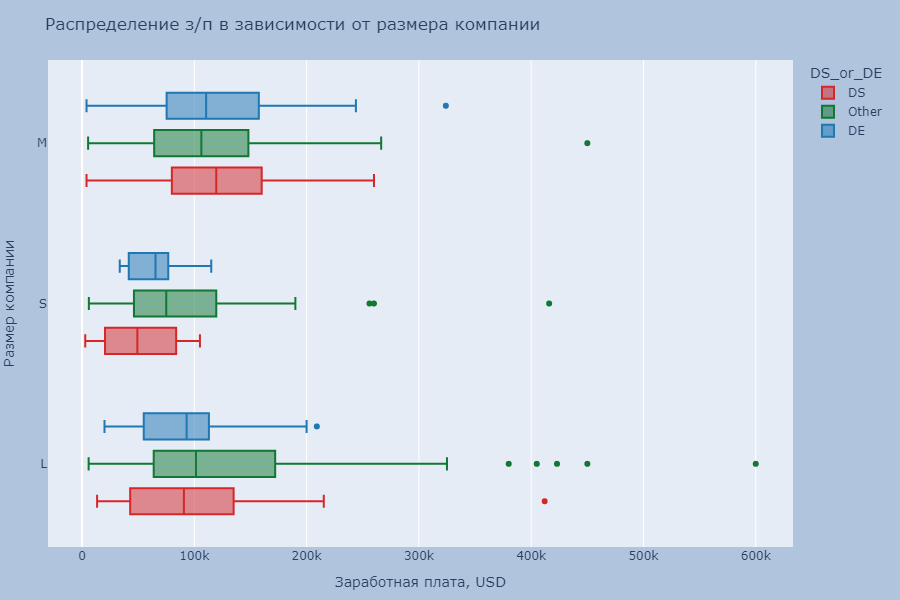

In [354]:
#строим график
fig = px.box(
    df, #табличные данные
    x='salary_in_usd', #ось абсцисс
    y='company_size', #ось ординат
    color='DS_or_DE', #выделение цветом
    color_discrete_sequence=[px.colors.qualitative.D3[3], px.colors.qualitative.Safe[3],
                             px.colors.qualitative.D3[0]], #настройка цвета
    title='Распределение з/п в зависимости от размера компании', #заголовок
    labels={'company_size':'Размер компании',
            'salary_in_usd':'Заработная плата, USD'}, #названия осей абсцисс и ординат
    height=600, #высота
    width=900 #ширина
)

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue'
)

#отображаем график
fig.show('png')

Наибольший уровень медианных з/п мы можем наблюдать в компаниях среднего размера. Компании большого размера платят своим сотрудникам немного меньше чем компании среднего размера. Меньше остальных получают DS в компаниях маленького размера. Почти везде выбросы.

#### Общий вывод по визуальному анализу.

В 20 и 21 годах заработная плата DS была ниже чем у остальных, ситуация изменилась в 2022 году - медианная заработная плата DS выросла настолько, что обогнала медианные з/п у категорий DE и Other, что говорит о стабильном росте и востребованности специалистов Data Scientist. У DS наблюдается ежегодный рост заработных плат судя по мединным зарплатам при распределении по годам. При распределении по опыту работы картина является стандартной - чем больше опыт, тем выше уровень заработной платы. По типу трудоустройства выводы будут некорректными в связи с малым количеством данных всех типов кроме полной занятости. Я нашла закономерность, что большинство сотрудников даже работая удаленно в основном работают в компаниях, имеющих офис в стране проживания сотрудника. Поэтому признак страны проживания сотрудника или признак страны нахождения главного офиса работодателя или филиала компании являются важными и влияют на уровень заработной платы специалиста DS. Размер компании также влияет на зарплату - маленькие, крупные, средние компании(размер компаний указан по возрастанию медианных заработных плат).

## Статистический анализ данных



In [13]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### 1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы для 2020-2021**

*Нулевая гипотеза* ($H_0$): заработная плата DS в 2020 году($μ_1$) выше, чем заработная плата DS в 2021 году($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): заработная плата DS в 2020 году($μ_1$) ниже, чем заработная плата DS в 2021 году($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [642]:
# знаечния заработных плат
salary_ds20 = df[(df['job_title']=='Data Scientist') & (df['work_year']==2020)]['salary_in_usd']
salary_ds21 = df[(df['job_title']=='Data Scientist') & (df['work_year']==2021)]['salary_in_usd']
salary_ds22 = df[(df['job_title']=='Data Scientist') & (df['work_year']==2022)]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(salary_ds20)
decision_normality(result[1])

print('2021:')
result = stats.shapiro(salary_ds21)
decision_normality(result[1])

print('2022:')
result = stats.shapiro(salary_ds22)
decision_normality(result[1])

2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [643]:
#очищаем от выбросов список з/п за 2020 год
quartile_1, quartile_3 = salary_ds20.quantile(0.25), salary_ds20.quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
salary_ds20_clean = salary_ds20[(salary_ds20 >= lower_bound) & (salary_ds20 <= upper_bound)]

In [644]:
# проводим тест Шапиро-Уилка на очищенных от выбросов данных
print('2020:')
result = stats.shapiro(salary_ds20_clean)
decision_normality(result[1])

2020:
p-value = 0.145
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [645]:
print('Исходные данные:', salary_ds20.shape[0], 'Очищенные:', salary_ds20_clean.shape[0])

Исходные данные: 21 Очищенные: 20


Разница в количестве небольшая, поэтому далее будем использовать очищенные от выбросов данные за 2020 год, так как они нормализованы.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать Двухвыборочный t-критерий.

**Проведём тест**

In [646]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_ds20_clean, salary_ds21)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.059
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [647]:
# проводим тест
# проводим тест на сравнение средних в группах
_, p = stats.ttest_ind(salary_ds20_clean, salary_ds21, alternative='less', equal_var=True)
decision_hypothesis(p)

p-value = 0.481
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


По результатам тестирования нельзя утверждать как изменился и изменился ли уровень заработных плат.

Проверим равенство или неравенство заработных плат 2020-2021:
* Нулевая гипотеза: заработные платы равны;
* Альтернативная: неравны.

In [648]:
_, p = stats.ttest_ind(salary_ds20_clean, salary_ds21, equal_var=True)
decision_hypothesis(p)

p-value = 0.962
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Результаты тестирования не дали однозначного ответа на вопрос "Выросли ли зарплаты у DS в 2020-2021 годах". По сравнению заработных плат можно сделать вывод(из-за значения p близкого к 1), что нулевая гипотеза очень близка. Предлагаю сравнить средние и медианные значения:

In [649]:
print('Средние значения за 2020 и 2021:', round(salary_ds20_clean.mean(), 3), ',', round(salary_ds21.mean(), 3))

Средние значения за 2020 и 2021: 69669.05 , 70215.773


In [650]:
print('Медианные значения за 2020 и 2021:', round(salary_ds20_clean.median(), 3), ',', round(salary_ds21.median(), 3))

Медианные значения за 2020 и 2021: 62726.0 , 67233.5


**Построим график**

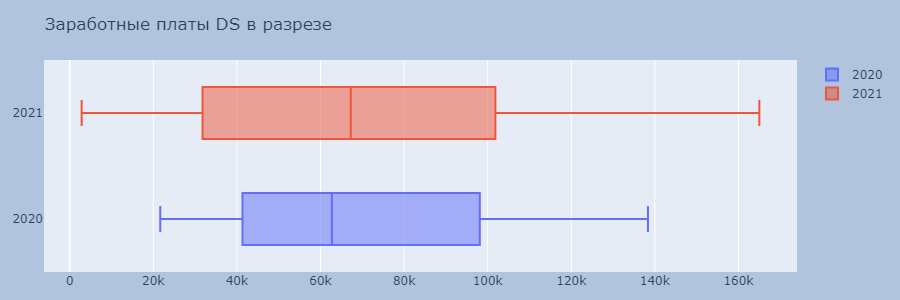

In [762]:
#строим график
fig = go.Figure()

fig.add_trace(go.Box(x=salary_ds20_clean, name='2020'))

fig.add_trace(go.Box(x=salary_ds21, name='2021'))

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    title='Заработные платы DS в разрезе',
    height=300,
    width=900
)

fig.show('png')

Разница конечно небольшая, но все же есть, к тому же у нас в этих годах наблюдается разница в количестве данных в два раза, поэтому считаю верным принять утверждение что уровень заработных плат Data Scientist в 2020 и 2021 годах вырос.

**Сформулируем нулевую и альтернативные гипотезы для 2021-2022**

*Нулевая гипотеза* ($H_0$): заработная плата DS в 2021 году($μ_1$) выше, чем заработная плата DS в 2022 году($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): заработная плата DS в 2021 году($μ_1$) ниже, чем заработная плата DS в 2022 году($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да. 

Для проверки нашей гипотезы можно использовать Двухвыборочный t-критерий.

In [655]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_ds21, salary_ds22)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [656]:
_, p = stats.ttest_ind(salary_ds21, salary_ds22, alternative='less', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


По результатам теста верно утверждение что уровень заработных плат DS выше в 2022 году по сравнению с 2021.

#### Выводы

Наблюдается ежегодный рост зарплат у специалистов Data Scientist, совсем небольшой и статистически незначимый в 2021 году и существенный и статистически значимый в 2022 году.

### 2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровень зарплат Data Scientist ($μ_1$) статистически меньше либо равен уровню зарплат Data Engineer ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Уровень зарплат Data Scientist ($μ_1$) статистически больше уровня зарплат Data Engineer ($μ_2$).
$$ H_1 : μ_1 > μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [657]:
# отбираем данные
salary_ds = df.loc[(df['job_title']=='Data Scientist') & (df['work_year']==2022), 'salary_in_usd']
salary_de = df.loc[(df['job_title']=='Data Engineer') & (df['work_year']==2022), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Data Scientist:')
result = stats.shapiro(salary_ds)
decision_normality(result[1])

print('Data Engineer:')
result = stats.shapiro(salary_de)
decision_normality(result[1])

Data Scientist:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Data Engineer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Очистим от выбросов зарплаты Data Engineer:

In [658]:
#очищаем от выбросов список з/п DE
quartile_1, quartile_3 = salary_de.quantile(0.25), salary_de.quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
salary_de_clean = salary_de[(salary_de >= lower_bound) & (salary_de <= upper_bound)]

In [659]:
# проводим тест Шапиро-Уилка на очищенных от выбросов данных
result = stats.shapiro(salary_de_clean)
decision_normality(result[1])

p-value = 0.021
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [667]:
print('Исходные данные:', salary_de.shape[0], 'Очищенные:', salary_de_clean.shape[0])

Исходные данные: 79 Очищенные: 78



К сожалению очистка от выбросов не помогла нормализовать данные, воспользуемся непараметрическими тестами.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [670]:
# проводим тест
_, p = stats.mannwhitneyu(salary_ds, salary_de_clean, alternative='greater')
decision_hypothesis(p)

p-value = 0.128
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


По результатам тестирования мы не можем отвергнуть нулевую гипотезу, значит однозначного ответа нет. Попробуем обратиться к сравнению медиан и средних.

In [671]:
print('Медиана DS:', salary_ds.median(), 'Медиана DE:', salary_de_clean.median(),
      'Среднее DS:', salary_ds.mean().round(3), 'Среднее DE:', salary_de_clean.mean().round(3))

Медиана DS: 135000.0 Медиана DE: 114000.0 Среднее DS: 131366.938 Среднее DE: 122096.038


#### Выводы

Тест не дал однозначного ответа, хотя значение p и было близко к значению alpha, значит по результатам теста мы не можем отказаться от нулевой гипотезы. При этом среднее значение зарплаты DS выше среднего DE, также и медианное значение у DS выше чем у DE, из чего можно сделать вывод что зарплата Data Scientist выше зарплаты Data Engineer в 2022 году. Но при этом статистически значимой разницы между ними не наблюдается.

### 3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: зарплаты специалистов Data Scientist в компаниях различных размеров не отличаются друг от друга: S — менее 50 сотрудников (небольшая компания) ($μ_1$), M — от 50 до 250 сотрудников (средняя компания) ($μ_2$), L — более 250 сотрудников (крупная компания) ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: зарплаты специалистов Data Scientist в компаниях различных размеров отличаются друг от друга: S — менее 50 сотрудников (небольшая компания) ($μ_1$), M — от 50 до 250 сотрудников (средняя компания) ($μ_2$), L — более 250 сотрудников (крупная компания) ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [672]:
# отбираем данные
s_salary = df.loc[(df['job_title']=='Data Scientist') & (df['company_size']=='S'), 'salary_in_usd']
m_salary = df.loc[(df['job_title']=='Data Scientist') & (df['company_size']=='M'), 'salary_in_usd']
l_salary = df.loc[(df['job_title']=='Data Scientist') & (df['company_size']=='L'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для компании размера "S":')
result = stats.shapiro(s_salary)
decision_normality(result[1])

print('Для компании размера "M":')
result = stats.shapiro(m_salary)
decision_normality(result[1])

print('Для компании размера "L":')
result = stats.shapiro(l_salary)
decision_normality(result[1])


Для компании размера "S":
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для компании размера "M":
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для компании размера "L":
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Очистим от выбросов зарплаты крупных компаний:

In [673]:
#очищаем от выбросов список з/п за 2020 год
quartile_1, quartile_3 = l_salary.quantile(0.25), l_salary.quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
l_salary_clean = l_salary[(l_salary >= lower_bound) & (l_salary <= upper_bound)]

In [674]:
# проводим тест Шапиро-Уилка на очищенных от выбросов данных
result = stats.shapiro(l_salary_clean)
decision_normality(result[1])

p-value = 0.030
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [675]:
print('Исходные данные:', l_salary.shape[0], 'Очищенные:', l_salary_clean.shape[0])

Исходные данные: 43 Очищенные: 42


Данные очищены от выбросов, но распределение все равно отличается от нормального, поэтому далее будем использовать  непараметрические тесты.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [676]:
# проводим тест
_, p = stats.kruskal(s_salary, m_salary, l_salary_clean)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


По результатам теста заработные платы DS отличаются в зависимости от размера компании.

**Будем проверять по частям: в начале сравним зарплаты специалистов из маленьких и средних компаний:**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровень зарплат Data Scientist в маленьких компаниях($μ_1$) статистически больше либо равен уровню зарплат Data Scientist в средних компанях ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): Уровень зарплат Data Scientist в маленьких компаниях($μ_1$) статистически меньше уровня зарплат Data Scientist в средних компаниях ($μ_2$).
$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да. 

Для проверки нашей гипотезы можно использовать Двухвыборочный t-критерий.

**Проведём тест**

In [677]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(s_salary, m_salary)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.018
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


In [678]:
# проводим тест на сравнение средних в группах
_, p = stats.ttest_ind(s_salary, m_salary, alternative='less', equal_var=False)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


DS в маленькой компании получает меньше чем в средней.

**Теперь сравним зарплаты специалистов из маленьких и крупных компаний:**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровень зарплат Data Scientist в маленьких компаниях($μ_1$) статистически больше либо равен уровню зарплат Data Scientist в крупных компанях ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): Уровень зарплат Data Scientist в маленьких компаниях($μ_1$) статистически меньше уровня зарплат Data Scientist в крупных компаниях ($μ_2$).
$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [680]:
# проводим тест
_, p = stats.mannwhitneyu(s_salary, l_salary_clean, alternative='less')
decision_hypothesis(p)

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


DS в маленькой компании получает меньше чем в крупной.

**Теперь сравним зарплаты специалистов из средних и крупных компаний:**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровень зарплат Data Scientist в средних компаниях($μ_1$) статистически меньше либо равен уровню зарплат Data Scientist в крупных компанях ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Уровень зарплат Data Scientist в средних компаниях($μ_1$) статистически больше уровня зарплат Data Scientist в крупных компаниях ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [681]:
# проводим тест
_, p = stats.mannwhitneyu(m_salary, l_salary_clean, alternative='greater')
decision_hypothesis(p)

p-value = 0.013
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


DS в средней компании получает больше чем в крупной.

#### Выводы

По возрастанию уровни заработных плат специалистов Data Scientist распределяются следующим образом:
* 1. Маленькие компании;
* 2. Крупные компании;
* 3. Средние компании.

### 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [682]:
# составляем таблицу сопряжённости
df_4 = df[(df['job_title']=='Data Scientist')|(df['job_title']=='Data Engineer')]
cross_table = pd.crosstab(df_4['company_size'], df_4['job_title'])

cross_table

job_title,Data Engineer,Data Scientist
company_size,,
L,34,43
M,81,66
S,6,21


In [683]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

### 5. Есть ли связь между основной страной проживания и страной главного офиса работодателя или филиала по контракту?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между основной страной проживания и страной главного офиса работодателя или филиала по контракту нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между основной страной проживания и страной главного офиса работодателя или филиала по контракту есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [684]:
# составляем таблицу сопряжённости

cross_table = pd.crosstab(df['company_size'], df['company_location'])

cross_table

company_location,AE,AS,AT,AU,BE,BR,CA,CH,CL,CN,...,PL,PT,RO,RU,SG,SI,TR,UA,US,VN
company_size,,,,,,,,,,,,,,,,,,,,,
L,1,0,2,1,0,0,11,2,1,1,...,4,3,0,1,1,2,1,1,102,0
M,0,0,1,1,2,2,14,0,0,1,...,0,1,1,1,0,0,2,0,186,1
S,2,1,1,1,0,1,3,0,0,0,...,0,0,0,0,0,0,0,0,30,0


In [685]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод

Существует статистически значимая взаимосвязь между основной страной проживания и страной главного офиса работодателя или филиала по контракту.

### 6. Проверим, правда ли, что средняя зарплата DS в 2022 году была выше средней заработной платы в США в 2022 году(США были выбраны, потому что по этой стране в таблице больше всего данных).

По данным Википедии в 2022 году в США средний размер оплаты труда в месяц(до вычета налогов) составлял 5407 долларов, таким образом в год заработная плата составляла 64884 доллара. США были выбраны, потому что по этой стране в таблице больше всего данных.

In [628]:
# проверим данные на нормальность
# отбираем данные
salary = df.loc[(df['job_title']=='Data Scientist') & (df['work_year']==2022), 'salary_in_usd']

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary)
decision_normality(result[1])

p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя зарплата DS в 2022 году($μ$) ниже или равна 64884 $.

$$ H_0 : μ <= 64884$$

*Альтернативная гипотеза* ($H_1$): средняя зарплата DS в 2022 году($μ$) выше 64884 $.

$$ H_0 : μ > 64884$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Да. 

Для проверки нашей гипотезы можно использовать одновыборочный t-критерий (t-test).

In [631]:
# проводим тест
_, p = stats.ttest_1samp(salary, popmean=64884, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод

По результатам тестирования средняя зарплата DS в 2022 году была выше средней заработной платы в США в 2022 году. Разница статистически значима.

### 7. Как соотносится средняя заработная плата Data Analyst со средней заработной платой по всем профессиям.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Средняя зарплата Data Analyst($μ_1$) статистически меньше либо равна средней заработной плате по всем профессиям($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Средняя зарплата Data Analyst($μ_1$) статистически выше средней заработной платы по всем профессиям($μ_2$).
$$ H_1 : μ_1 > μ_2$$

In [639]:
da_salary = df.loc[df['job_title']=='Data Analyst', 'salary_in_usd']
salary = df['salary_in_usd']

In [640]:
# проводим тест Шапиро-Уилка
result = stats.shapiro(da_salary)
decision_normality(result[1])

result = stats.shapiro(salary)
decision_normality(result[1])

p-value = 0.829
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [686]:
#очищаем от выбросов список з/п за 2020 год
quartile_1, quartile_3 = salary.quantile(0.25), salary.quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
salary_clean = salary[(salary >= lower_bound) & (salary <= upper_bound)]

In [687]:
# проводим тест Шапиро-Уилка на очищенных от выбросов данных
result = stats.shapiro(salary_clean)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [688]:
print('Исходные данные:', salary.shape[0], 'Очищенные:', salary_clean.shape[0])

Исходные данные: 565 Очищенные: 555


Очистка от выбросов не помогла нормализовать данные, поэтому будет использовать непараметрические тесты.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [693]:
# проводим тест
_, p = stats.mannwhitneyu(da_salary, salary_clean, alternative='greater')
decision_hypothesis(p)

p-value = 0.960
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


По результатам тестирования у нас нет оснований отвергать нулевую гипотезу, обратимся к визуальному анализу:

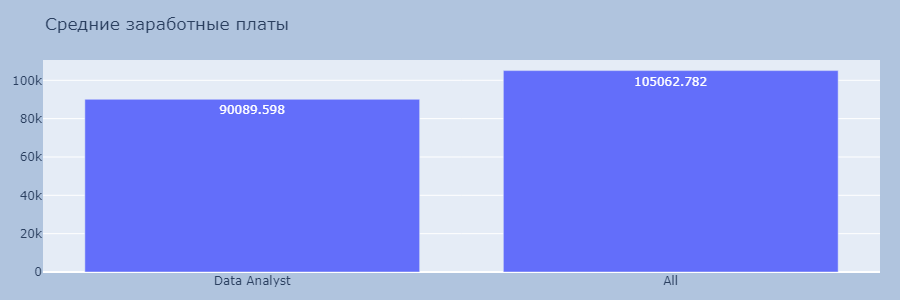

In [774]:
x = ['Data Analyst', 'All']
y = [da_salary.values.mean().round(3), salary_clean.values.mean().round(3)]

#строим график
fig = go.Figure(data = [go.Bar(x=x, y=y, text=y, textposition='auto')])

#форматирование
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    title='Средние заработные платы',
    height=300,
    width=900
)

fig.show('png')

По графику видна разница средних зарплат - у DA заработная плата меньше, чем средняя по всей таблице. В таком случае проверим эту гипотезу с помощью статистического теста.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Средняя зарплата Data Analyst($μ_1$) статистически больше либо равна средней заработной плате по всем профессиям($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): Средняя зарплата Data Analyst($μ_1$) статистически меньше средней заработной платы по всем профессиям($μ_2$).
$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата, USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [773]:
# проводим тест
_, p = stats.mannwhitneyu(da_salary, salary_clean, alternative='less')
decision_hypothesis(p)

p-value = 0.040
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Отлично, по результатам тестирования мы отвергаем нулевую гипотезу, чем получаем подтверждение альтернативной гипотезы - средняя заработная плата Data Analyst меньше средней заработной платы по всем профессиям.

***

## Итоговые результаты исследования

*   Наблюдается ежегодный рост зарплат у специалистов Data Scientist, совсем небольшой и статистически незначимый в 2021 году и существенный и статистически значимый в 2022 году.
*   Среднее значение зарплаты DS выше среднего DE, также и медианное значение у DS выше чем у DE, из чего можно сделать вывод что зарплата Data Scientist выше зарплаты Data Engineer в 2022 году. Но при этом статистически значимой разницы между ними не наблюдается.
*   По возрастанию уровни заработных плат специалистов Data Scientist распределяются следующим образом:
    * 1. Маленькие компании;
    * 2. Крупные компании;
    * 3. Средние компании.
*   Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

* Существует статистически значимая взаимосвязь между основной страной проживания и страной главного офиса работодателя или филиала по контракту.
* Средняя зарплата DS в 2022 году была выше средней заработной платы в США в 2022 году.
* Средняя заработная плата Data Analyst меньше средней заработной платы по всем профессиям.

На зарплату специалиста Data Scientist имеют влияние следующие факторы:
* опыт работы;
* страна проживания сотрудника;
* страна главного офиса работодателя или филиала по контракту;
* размер компании(среднее количество людей, работавших в компании в течение года).
Возможно ещё имеет влияние "тип трудоустройства", но данных во всех категориях кроме "полный рабочий день" недостаточно.